In [0]:
# Download transformers (BERT)
! test -d transformers || git clone https://github.com/huggingface/transformers
! cd transformers && pip install .
# Download and load HANS data.
! test -d hans || git clone https://github.com/tommccoy1/hans.git


Cloning into 'transformers'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 24682 (delta 12), reused 23 (delta 6), pack-reused 24646
Receiving objects: 100% (24682/24682), 14.93 MiB | 25.52 MiB/s, done.
Resolving deltas: 100% (17317/17317), done.
Processing /content/transformers
     |████████████████████████████████| 3.8MB 4.5MB/s 
     |████████████████████████████████| 1.0MB 44.2MB/s 
     |████████████████████████████████| 890kB 54.5MB/s 
  Created wheel for transformers: filename=transformers-2.8.0-cp36-none-any.whl size=585132 sha256=8d585efae27fc3421f51eea8dcc58056f504db83af87dbff4c772291222dad17
  Stored in directory: /tmp/pip-ephem-wheel-cache-1gwop_7t/wheels/23/19/dd/2561a4e47240cf6b307729d58e56f8077dd0c698f5992216cf
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=ae4d62a4759f2197d42048cc89e9a0a9d16300e96bea18fd291d70e9ab3e2818

In [0]:
import os
import sys
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def set_seed(seed):
  #random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
set_seed(42)

In [0]:
! test -d structural-probes || git clone https://github.com/john-hewitt/structural-probes/
! pip install pytorch-pretrained-bert
! cd structural-probes
! bash structural-probes/download_example.sh


Cloning into 'structural-probes'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 258 (delta 0), reused 1 (delta 0), pack-reused 254
Receiving objects: 100% (258/258), 585.35 KiB | 2.23 MiB/s, done.
Resolving deltas: 100% (194/194), done.
     |████████████████████████████████| 133kB 4.9MB/s 
--2020-04-25 04:24:07--  https://nlp.stanford.edu/~johnhew/public/en_ewt-ud-sample.tgz
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43733896 (42M) [application/x-tar]
Saving to: ‘en_ewt-ud-sample.tgz’

en_ewt-ud-sample.tg 100%[===================>]  41.71M  5.89MB/s    in 7.9s    

2020-04-25 04:24:15 (5.31 MB/s) - ‘en_ewt-ud-sample.tgz’ saved [43733896/43733896]

--2020-04-25 04:24:15--  https://nlp.stanford.edu/~johnhew/public/sp/bertlarge16-dista

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Constructing TwoWordPSDProbe
Constructing OneWordPSDProbe



Constructing TwoWordPSDProbe
Constructing OneWordPSDProbe
Without a doubt the professor introduced the student (8, 8) (8, 1024)


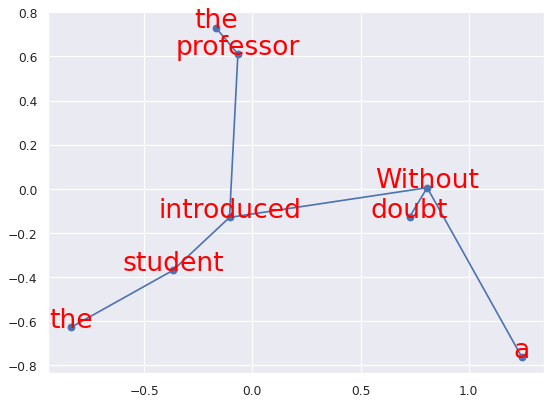

The professor introduced the student (5, 5) (5, 1024)


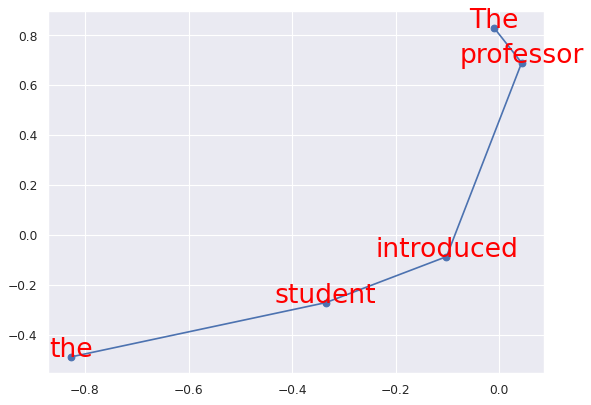

In [0]:
if not os.path.abspath('structural-probes/structural-probes') in sys.path:
  sys.path += [os.path.abspath('structural-probes/structural-probes')]

from probe import TwoWordPSDProbe, OneWordPSDProbe
from data import SubwordDataset
from reporter import prims_matrix_to_edges
from run_demo import print_distance_image, print_depth_image
import seaborn as sns
from sklearn.decomposition import PCA
    

sns.set(style="darkgrid")

%matplotlib inline 

args = {
'model':{
  'hidden_dim': 1024, # hidden dim
  'model_type': 'BERT-disk', # BERT-disk, ELMo-disk, 
  'use_disk': False,
  'model_layer': 16 # BERT-base: {1,...,12}; ELMo: {1,2,3}
  },
'probe':{
  'task_name': 'demo',
  'maximum_rank': 1024,
  'psd_parameters': True,
  'depth_params_path': 'example/data/bertlarge16-depth-probe.params',
  'distance_params_path': 'example/data/bertlarge16-distance-probe.params'
  },
'reporting': {
  'root': 'example/results'
  },
'device': device,
}


"""
Probe Distance and depth, 
modified from structural-probes/demo.py
"""
def BertRepresentation(words):
  # Define the BERT model and tokenizer
  model_type = 'bert-large-cased'
  tokenizer = BertTokenizer.from_pretrained(model_type)
  model = BertModel.from_pretrained(model_type, output_hidden_states=True)
  LAYER_COUNT = 24
  FEATURE_COUNT = 1024
  model.to(args['device'])
  model.eval()
  nwords = len(words)
  # Tokenize the sentence and create tensor inputs to BERT
  tokenized_sent = tokenizer.wordpiece_tokenizer.tokenize('[CLS] ' + ' '.join(words) + ' [SEP]')
  untok_tok_mapping = SubwordDataset.match_tokenized_to_untokenized(tokenized_sent, words)

  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_sent)
  segment_ids = [1 for x in tokenized_sent]

  tokens_tensor = torch.tensor([indexed_tokens])
  segments_tensors = torch.tensor([segment_ids])

  tokens_tensor = tokens_tensor.to(args['device'])
  segments_tensors = segments_tensors.to(args['device'])
  with torch.no_grad():
    # Run sentence tensor through BERT after averaging subwords for each token
    #encoded_layers, _  = model(tokens_tensor, segments_tensors)
    _, _, encoded_layers  = model(tokens_tensor, segments_tensors)
    single_layer_features = encoded_layers[args['model']['model_layer']+1]
    representation = torch.stack([torch.mean(single_layer_features[0,untok_tok_mapping[i][0]:untok_tok_mapping[i][-1]+1,:], dim=0) for i in range(nwords)], dim=0)
    representation = representation.view(1, *representation.size())
    representation.to(args['device'])
  return representation


def get_distance_depth(words):
  nwords = len(words)
  # Define the distance probe
  distance_probe = TwoWordPSDProbe(args)
  distance_probe.load_state_dict(torch.load(args['probe']['distance_params_path'], map_location=args['device']))

  # Define the depth probe
  depth_probe = OneWordPSDProbe(args)
  depth_probe.load_state_dict(torch.load(args['probe']['depth_params_path'], map_location=args['device']))
  # Run BERT token vectors through the trained probes
  representation = BertRepresentation(words)
  distance = distance_probe(representation).detach().cpu()[0][:nwords,:nwords].numpy()
  depth = depth_probe(representation).detach().cpu()[0][:nwords].numpy()
  transformed = torch.matmul(representation, distance_probe.proj).detach().cpu()[0][:nwords].numpy()
  return distance, depth, transformed

def visualize_distance(words, prediction):
  plt.figure(num=None, figsize=(8, 6), dpi=80)
  plt.clf()
  ax = sns.heatmap(distance)
  ax.set_title('Predicted Parse Distance (squared)')
  ax.set_xticks(np.arange(len(words)))
  ax.set_yticks(np.arange(len(words)))
  ax.set_xticklabels(words, rotation=90, fontsize=12, ha='center')
  ax.set_yticklabels(words, rotation=0, fontsize=12, va='center')
  plt.tight_layout()
  plt.show()
 
def visualize_depth(words, prediction):
  plt.figure(num=None, figsize=(8, 6), dpi=80)
  plt.clf()
  fontsize = 12
  cumdist = 0
  for index, (word, pred) in enumerate(zip(words, prediction)):
    plt.text(cumdist*3, pred*2, word, fontsize=fontsize, color='red', ha='center')
    cumdist = cumdist + (np.square(len(word)) + 1)
  plt.ylim(0,20)
  plt.xlim(0,cumdist*3.5)
  plt.title('Predicted Parse Depth (squared)', fontsize=16)
  plt.ylabel('Tree Depth', fontsize=16)
  plt.xlabel('Linear Absolute Position',fontsize=16)
  plt.tight_layout()
  plt.xticks(fontsize=10)
  plt.yticks(fontsize=10)
  plt.show()



def visualize_edges(edges, points, words):
  plt.figure(num=None, figsize=(8, 6), dpi=80)
  plt.clf()
  plt.scatter(points[:,0],points[:,1])
  for idx, w in enumerate(words):
    plt.text(points[idx,0], points[idx,1], w, fontsize=24, color='red', ha='center')
  for ij in edges:
    plt.plot(points[ij,0],points[ij,1],'b')
  plt.show()



def get_tikz(prediction_edges, words):
  string = """\n\n\\begin{dependency}[hide label, edge unit distance=.5ex]
        \\begin{deptext}[column sep=0.05cm]
        """
  string += "\\& ".join([x.replace('$', '\$').replace('&', '+') for x in words]) + " \\\\" + '\n'
  string += "\\end{deptext}" + '\n'
  for i_index, j_index in prediction_edges:
    string += '\\depedge[edge style={{red!60!}}, edge below]{{{}}}{{{}}}{{{}}}\n'.format(i_index+1,j_index+1, '.')
  string += '\\end{dependency}\n'
  return string



#sentence = "The chef that went to the stores was out of food"
def syntatic_structure(sentence):
  words = sentence.strip().split()
  distance, depth, transformed = get_distance_depth(words)
  pca = PCA(n_components=2)
  points = pca.fit_transform(transformed)
  #p1 = np.expand_dims(points,1)
  #p2 = np.repeat(p1, len(words), 1)
  #dp = p2-p2.transpose((1,0,2))
  #distance2 = np.sum(np.power(dp,2),2) 
  #visualize_distance(words, distance)
  #visualize_depth(words, depth)
  edges = prims_matrix_to_edges(distance, words, words) 
  visualize_edges(edges, points, words)
  #edges2 = prims_matrix_to_edges(distance2, words, words) 
  #visualize_edges(edges2, points, words)

def syntatic_structure_sentence_pair(sentence1, sentence2):
  sentence_pair = [sentence1, sentence2]
  distance_pair = []
  transformed_pair = []
  for sentence in sentence_pair:
    words = sentence.strip().split()
    distance, depth, transformed = get_distance_depth(words)
    distance_pair += [distance]
    transformed_pair += [transformed]
  pca = PCA(n_components=2)
  pca.fit(np.concatenate(transformed_pair, axis=0))
  for sentence, distance, transformed in zip(sentence_pair, distance_pair, transformed_pair):
    words = sentence.strip().split()
    print(sentence, distance.shape, transformed.shape)
    points = pca.transform(transformed)
    edges = prims_matrix_to_edges(distance, words, words) 
    visualize_edges(edges, points, words)
  


#syntatic_structure("The chef that went to the stores was out of food")
syntatic_structure_sentence_pair("Without a doubt the professor introduced the student","The professor introduced the student")

In [0]:
import pandas as pd
txt_train = 'hans/heuristics_train_set.txt'
txt_eval = 'hans/heuristics_evaluation_set.txt'
df_train = pd.read_csv(txt_train,sep='\t')
df_eval = pd.read_csv(txt_eval,sep='\t')

for idx in range(5,30000,1000):
  print(df_train.sentence1[idx], df_train.sentence2[idx], df_train.gold_label[idx], df_train.heuristic[idx], df_train.subcase[idx])
  sentence1 = df_train.sentence1[idx].replace('.','')
  sentence2 = df_train.sentence2[idx].replace('.','')
  syntatic_structure_sentence_pair(sentence1,sentence2)

In [0]:

if not os.path.abspath('transformers/examples/hans/') in sys.path:
  sys.path += [os.path.abspath('transformers/examples/hans/')]

from transformers import BertForSequenceClassification, BertTokenizer
from transformers import glue_convert_examples_to_features as convert_examples_to_features

from transformers import glue_output_modes as output_modes
from transformers import glue_processors as processors
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler, RandomSampler, Subset
from transformers.data.processors.utils import DataProcessor, InputExample
class HansProcessor(DataProcessor):
    def get_train_examples(self, data_dir):
      return self._create_examples(self._read_tsv(os.path.join(data_dir, "heuristics_train_set.txt")), "train")

    def get_dev_examples(self, data_dir):
      return self._create_examples(self._read_tsv(os.path.join(data_dir, "heuristics_evaluation_set.txt")), "dev")

    def get_labels(self):
      return ["non-entailment", "entailment"]

    def _create_examples(self, lines, set_type):
      examples = []
      for (i, line) in enumerate(lines):
        if i == 0:
            continue
        guid = "%s-%s" % (set_type, line[7][2:] if line[7].startswith("ex") else line[7])
        text_a = line[5]
        text_b = line[6]
        label = line[0]
        examples.append(InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
      return examples

processors["hans"] = HansProcessor
output_modes["hans"] = "classification"
model_type = 'bert-large-cased'
tokenizer = BertTokenizer.from_pretrained(model_type)

'''
load_and_cache_examples function, modified from test_hans.py
'''
def load_and_cache_examples(tokenizer, evaluate = False, task = 'hans', data_dir='hans', max_seq_length=32):
  processor = processors[task]()
  output_mode = output_modes[task]
  # Load data features from cache or dataset file
  cached_features_file = os.path.join(data_dir,"cache")
  label_list = processor.get_labels()

  if os.path.exists(cached_features_file) and not args.overwrite_cache:
    print("Loading features from cached file {}".format(cached_features_file))
    features = torch.load(cached_features_file)
  else:
    print("Creating features from dataset file at {}".format(data_dir))
    examples = (processor.get_dev_examples(data_dir) if evaluate else processor.get_train_examples(data_dir))
    print(examples)
    features = convert_examples_to_features(
      examples,
      tokenizer,
      label_list=label_list,
      max_length=max_seq_length,
      output_mode=output_mode,
    )

  # Convert to Tensors and build dataset
  all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
  all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
  all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
  if output_mode == "classification":
    all_labels = torch.tensor([f.label for f in features], dtype=torch.long)
  elif output_mode == "regression":
    all_labels = torch.tensor([f.label for f in features], dtype=torch.float)

  dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)
  return dataset, label_list





In [0]:
!pip install umap-learn
!pip install hdbscan
import umap
import hdbscan

train_dataset, _ = load_and_cache_examples(tokenizer)


def search_string_in_df(df, word):
  indices = []
  for i in range(len(df)):
    if word in df.sentence1[i] and word in df.sentence2[i]:
      indices += [i]
  return indices


word = 'knew' # the word to probe
batch_size = 64
indices = search_string_in_df(df_train,'knew')
idx = indices[0]
print(df_train.sentence1[idx], df_train.sentence2[idx], df_train.gold_label[idx], df_train.heuristic[idx], df_train.subcase[idx])

probe_dataset = Subset(train_dataset,indices)
probe_sampler = SequentialSampler(probe_dataset)
probe_dataloader = DataLoader(probe_dataset, sampler=probe_sampler, batch_size=batch_size)


LAYER_COUNT = 24
FEATURE_COUNT = 1024
probe_layer = 16

model = BertForSequenceClassification.from_pretrained(model_type, output_hidden_states=True)
model.to(device)
model.eval()

word_id = tokenizer.encode(word,add_special_tokens=False)[0]
word_embedding_all = None
i_all = None
j_all = None
for i,batch in enumerate(tqdm(probe_dataloader, desc="Extract word senses")):
  #find the index of the word id
  ix, iy = (batch[0] == word_id).nonzero(as_tuple=True)
  batch = tuple(t.to(device) for t in batch)
  with torch.no_grad():
    inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[3]}
    if model_type != "distilbert":
      inputs["token_type_ids"] = (
          batch[2] if model_type in ["bert", "xlnet"] else None
      )  # XLM, DistilBERT and RoBERTa don't use segment_ids
    outputs = model(**inputs)
    _, _, encoded_layers = outputs
    single_layer_features = encoded_layers[probe_layer+1]
    word_embedding = single_layer_features[ix,iy,:].reshape(-1,FEATURE_COUNT).detach().cpu().numpy()
    if word_embedding_all is None:
      word_embedding_all = word_embedding
      i_all = ix + i * batch_size
      j_all = iy
    else:
      word_embedding_all = np.concatenate((word_embedding_all, word_embedding), axis=0)
      i_all = np.concatenate((i_all, ix + i * batch_size), axis = 0)
      j_all = np.concatenate((j_all, iy), axis = 0)

reducer = umap.UMAP()
embedding = reducer.fit_transform(word_embedding_all)




     |████████████████████████████████| 4.7MB 4.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.26-cp36-cp36m-linux_x86_64.whl size=2361290 sha256=e5b54b08d3da3a9e0073005d34f68a05215ea49408255f3df2e2b851017d0ee2
  Stored in directory: /root/.cache/pip/wheels/82/38/41/372f034d8abd271ef7787a681e0a47fc05d472683a7eb088ed
Successfully built hdbscan
Creating features from dataset file at hans


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



The author knew the senators danced . The author knew the senators . non-entailment subsequence sn_NP/S


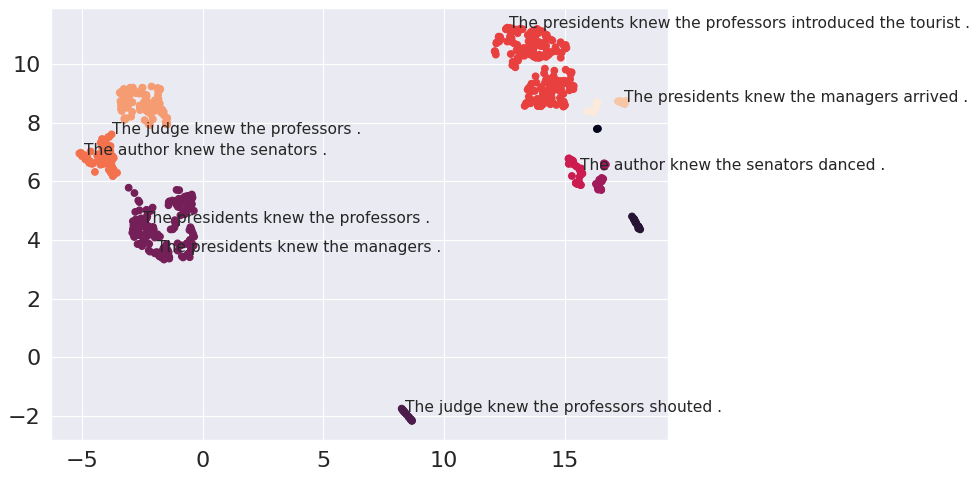

In [0]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
cluster_labels = clusterer.fit_predict(embedding)
plt.figure(num=None, figsize=(12, 6), dpi=80)
plt.scatter(embedding[:,0],embedding[:,1],c=cluster_labels)

for i in [0,40,80,120]:
  idx = indices[i]
  plt.text(embedding[2*i,0],embedding[2*i,1], df_train.sentence1[idx], fontsize=14)
  plt.text(embedding[2*i+1,0],embedding[2*i+1,1], df_train.sentence2[idx], fontsize=14)
plt.tight_layout()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [0]:
# Use TPU and pytorch xla
VERSION = "1.5"
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION
import torch_xla.core.xla_model as xm

device = xm.xla_device()

In [0]:
! test -d download_glue || git clone https://gist.github.com/60c2bdb54d156a41194446737ce03e2e.git download_glue
! test -d glue_data/MNLI || python download_glue/download_glue_data.py --data_dir='glue_data' --tasks=MNLI

from transformers import BertPreTrainedModel
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers.activations import gelu
from torch import nn
from transformers.file_utils import add_start_docstrings, add_start_docstrings_to_callable
class MyBertSequentialClassification(BertPreTrainedModel):
  def __init__(self, config):
    super().__init__(config)
    self.num_labels = config.num_labels
    self.bert = BertModel(config)
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    self.reduction = 16
    ex_hidden = config.hidden_size // self.reduction
    self.excitation = nn.Sequential(
              nn.Linear(config.hidden_size, ex_hidden),
              nn.GELU(),
              nn.Linear(ex_hidden, ex_hidden),
              nn.Sigmoid(),
              nn.Linear(ex_hidden, config.hidden_size))
    self.classifier = nn.Linear(config.hidden_size, self.config.num_labels)
    self.init_weights()

  def forward(self,input_ids=None,attention_mask=None,token_type_ids=None,
        position_ids=None,head_mask=None,inputs_embeds=None,labels=None):
    outputs = self.bert(input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids,
      position_ids=position_ids,
      head_mask=head_mask,
      inputs_embeds=inputs_embeds,
    )

    pooled_output = outputs[1]
    scale = self.excitation(pooled_output)
    pooled_output = self.dropout(pooled_output) * self.dropout(scale)
    logits = self.classifier(pooled_output)

    outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

    if labels is not None:
      if self.num_labels == 1:
          #  We are doing regression
          loss_fct = nn.MSELoss()
          loss = loss_fct(logits.view(-1), labels.view(-1))
      else:
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
      outputs = (loss,) + outputs

    return outputs  # (loss), logits, (hidden_states), (attentions)


#train_dataset = load_and_cache_examples(tokenizer, task = 'mnli', data_dir = 'glue_data/MNLI', max_seq_length=128)




In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
path_checkpoint='/content/gdrive/My Drive'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!mkdir cache
!mkdir runs
if not os.path.abspath('transformers/examples') in sys.path:
  sys.path += [os.path.abspath('transformers/examples')]

import argparse 
import run_tpu_glue
args = argparse.Namespace(
      model_type="bert", 
      model_name_or_path="bert-base-cased",
      task_name="mnli",
      data_dir="glue_data/MNLI",
      output_dir="/content/gdrive/My Drive",
      max_seq_length=128,
      train_batch_size=64,
      eval_batch_size=16,
      learning_rate=5e-5,
      num_train_epochs=1,
      do_train=True,
      do_eval=True,
      evaluate_during_training=False,
      local_rank=-1,
      n_gpu=1,
      max_steps=5000,
      gradient_accumulation_steps=1,
      overwrite_cache=False,
      overwrite_output_dir=False,
      weight_decay=1e-5,
      adam_epsilon=1e-8,
      max_grad_norm=1.0,
      warmup_steps=0,
      logging_steps=500,
      save_steps=5000,
      eval_all_checkpoints=False,
      metrics_debug=False,
      no_cuda=False,
      seed=42,
      fp16=False,
      device=device,
      cache_dir = "cache",
      tensorboard_logdir = "./runs",
      output_mode="classification",
      )



model_type = 'bert-base-cased' 
tokenizer = BertTokenizer.from_pretrained(model_type)
#checkpoint = "/content/gdrive/My Drive/checkpoint-5000"
checkpoint = None
if not checkpoint:
  #fine-tune the model
  print("Loading MNLI data: takes several minutes. ")
  train_dataset = run_tpu_glue.load_and_cache_examples(args, 'mnli', tokenizer, evaluate=False)
  config = BertConfig.from_pretrained(model_type, num_labels = 3)
  model = MyBertSequentialClassification.from_pretrained(model_type, config=config)
  model.to(device)
  print("Start training")
  run_tpu_glue.tqdm = tqdm
  run_tpu_glue.trange = trange 
  global_step, tr_loss = run_tpu_glue.train(args, train_dataset, model, tokenizer)
else:
  model = MyBertSequentialClassification.from_pretrained(checkpoint)
  model.to(device)



mkdir: cannot create directory ‘cache’: File exists
mkdir: cannot create directory ‘runs’: File exists
Loading MNLI data: takes several minutes. 
Start training


/pytorch/torch/csrc/utils/python_arg_parser.cpp:749: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, Number alpha)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


In [0]:
print("Loading HANS data...")
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import torch_xla.distributed.parallel_loader as pl
args.task_name='hans'
args.data_dir='hans'
run_tpu_glue.processors["hans"]=HansProcessor
run_tpu_glue.output_modes["hans"]="classification"

def hans_accuracy(preds, labels):
  non_entailed = (labels == 0)
  non_entailed_correct = ((preds == 0) & non_entailed)
  entailed = (labels == 1)
  entailed_correct = ((preds == 1) & entailed)
  start = 0
  end = 10000
  non_entailed_acc = {}
  entailed_acc = {}
  for heuristic in ['lexical_overlap', 'subsequence', 'constituent']:
    non_entailed_acc[heuristic] = non_entailed_correct[start:end].sum() / non_entailed[start:end].sum()
    entailed_acc[heuristic] = entailed_correct[start:end].sum() / entailed[start:end].sum()
    start += 10000
    end += 10000

  return {'num':preds.shape[0], 
      'entailed_acc': entailed_acc,
      'non_entailed_acc': non_entailed_acc}
  
""" modified from run_tpu_glue """
def evaluate(args, model, tokenizer, prefix="", disable_logging=False):
  """Evaluate the model"""
  # Loop to handle MNLI double evaluation (matched, mis-matched)
  eval_dataset = run_tpu_glue.load_and_cache_examples(args, args.task_name, tokenizer, evaluate=True)
  eval_sampler = SequentialSampler(eval_dataset)
  if not os.path.exists(args.output_dir):
      os.makedirs(args.output_dir)
  dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size, shuffle=False)
  eval_dataloader = pl.ParallelLoader(dataloader, [args.device]).per_device_loader(args.device)
  # Eval!
  eval_loss = 0.0
  nb_eval_steps = 0
  preds = None
  out_label_ids = None
  for batch in tqdm(eval_dataloader, desc="Evaluating", disable=disable_logging):
    model.eval()
    with torch.no_grad():
      inputs = {"input_ids": batch[0], "attention_mask": batch[1], "token_type_ids" : batch[2], "labels": batch[3]}
      outputs = model(**inputs)
      batch_eval_loss, logits = outputs[:2]
      eval_loss += batch_eval_loss
    nb_eval_steps += 1
    if preds is None:
      preds = logits.detach().cpu().numpy()
      out_label_ids = inputs["labels"].detach().cpu().numpy()
    else:
      it = logits.detach().cpu().numpy()
      preds = np.append(preds, it, axis=0)
      out_label_ids = np.append(out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0)

  # tpu-comment: Get all predictions and labels from all worker shards of eval dataset
  #preds = xm.mesh_reduce("eval_preds", preds, np.concatenate)
  #out_label_ids = xm.mesh_reduce("eval_out_label_ids", out_label_ids, np.concatenate)
  eval_loss = eval_loss / nb_eval_steps
  if args.output_mode == "classification":
    preds = np.argmax(preds, axis=1)
  elif args.output_mode == "regression":
    preds = np.squeeze(preds)
  return preds, out_label_ids, eval_loss.item() 

preds, out_label_ids, loss = evaluate(args,model,tokenizer)

#write results to a file
output_file = os.path.join(args.output_dir, "hans_eval_results.txt")
if xm.is_master_ordinal():
  with open(output_file, "w") as writer:
    writer.write("pairID\tgold_label\tpred\n")
    label_list = run_tpu_glue.processors[args.task_name]().get_labels()
    for i in range(len(preds)):
      #gold = label_list[out_label_ids[i]]
      #pred = label_list[preds[i]]
      #writer.write("ex{}\t{}\t{}\n".format(i, gold, pred))
      writer.write("ex{}\t{}\t{}\n".format(i, out_label_ids[i], preds[i]))
# convert mnli to hans labels
preds = (preds == 1)
results = hans_accuracy(preds, out_label_ids)
print(results)


Loading HANS data...



{'num': 30000, 'entailed_acc': {'lexical_overlap': 0.9966, 'subsequence': 1.0, 'constituent': 0.9946}, 'non_entailed_acc': {'lexical_overlap': 0.0112, 'subsequence': 0.0182, 'constituent': 0.0266}}
